In [1]:
"""
The classic game of flappy bird. Make with python
and pygame. Features pixel perfect collision using masks :o
Date Modified:  Jul 30, 2019
Author: Tech With Tim
Estimated Work Time: 5 hours (1 just for that damn collision)
"""
import pygame
import random
import os
import time
import numpy as np
import math
import torch
import torch.nn.functional
import matplotlib.pyplot as plt
import torch.optim as opt
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import torch.nn as nn
import scipy.stats as st
from sklearn.datasets.samples_generator import make_blobs
from matplotlib.colors import LogNorm 
import matplotlib.cm as cm

if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  

print(dev)


pygame 2.0.1 (SDL 2.0.14, Python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html
cuda:0


D:\ComputerSoftwares\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
global target_order
target_order = "supervised"
global temp_list
temp_list = []
Agent_number_n=4;
Alpha = (1-0.625);

# torch.manual_seed(1)    # reproducible
# np.random.seed(1)

# Hyper Parameters
BATCH_SIZE = 64
LR_G = 0.00001           # learning rate for generator
LR_D = 0.00001           # learning rate for discriminator
N_IDEAS = Agent_number_n             # think of this as number of ideas for generating an art work (Generator)
ART_COMPONENTS = Agent_number_n     # it could be total point G can draw in the canvas
PAINT_POINTS = np.vstack([np.linspace(-1, 1, ART_COMPONENTS) for _ in range(BATCH_SIZE)])


GeneratorNet = nn.Sequential(                      # Generator
    # random ideas (could from normal distribution)
    nn.Linear(N_IDEAS, 128),
    nn.ReLU(),
    # making a painting from these random ideas
    nn.Linear(128, ART_COMPONENTS),
)
#GeneratorNet = torch.load("save/GeneratorNet_4_1") 

In [3]:
def appen(_x_list,y):
    global temp_list
    temp_list.append(_x_list)
    
def appen_train(x_list):
    global temp_list
                
    S= max(sum(x_list),1.0);
    temp_list = []
    
    for i in range(Agent_number_n):
        temp = []
        for j in range(Agent_number_n):
            if(i!=j):
                temp.append(x_list[j])
        appen(temp,S)
    
    training_data.append(temp_list)
    training_label.append(S)
    

def read_training_data():
    for i in range(100000):
        appen_train(np.random.rand(Agent_number_n));

training_data=[]
training_label=[]
S=1.0
read_training_data();

def appen_test(x_list):
    global temp_list
                
    S= max(sum(x_list),1.0);
    temp_list = []
    
    for i in range(Agent_number_n):
        temp = []
        for j in range(Agent_number_n):
            if(i!=j):
                temp.append(x_list[j])
        appen(temp,S)
    testing_data.append(temp_list)
    testing_label.append(S)
    

def read_testing_data():
#     devided=20
#     for i1 in range(devided+1):
#         for i2 in range(i1+1):
#             for i3 in range(i2+1):
#                 appen_test(i1/devided,i2/devided,i3/devided);
    for i in range(10000):
        appen_test(np.random.rand(Agent_number_n));
                            

testing_data=[]
testing_label=[]
S=1.0
read_testing_data();

training_data=np.array(training_data)
training_label=np.array(training_label)
testing_data=np.array(testing_data)
testing_label=np.array(testing_label)
print(training_data)
print(testing_data)
print(training_label)
print(testing_label)

[[[0.41243112 0.92976805 0.03881144]
  [0.53027182 0.92976805 0.03881144]
  [0.53027182 0.41243112 0.03881144]
  [0.53027182 0.41243112 0.92976805]]

 [[0.5223657  0.92891609 0.45489822]
  [0.8784346  0.92891609 0.45489822]
  [0.8784346  0.5223657  0.45489822]
  [0.8784346  0.5223657  0.92891609]]

 [[0.47827265 0.96303809 0.2679296 ]
  [0.61023923 0.96303809 0.2679296 ]
  [0.61023923 0.47827265 0.2679296 ]
  [0.61023923 0.47827265 0.96303809]]

 ...

 [[0.53109207 0.57349623 0.64642121]
  [0.51379011 0.57349623 0.64642121]
  [0.51379011 0.53109207 0.64642121]
  [0.51379011 0.53109207 0.57349623]]

 [[0.63888755 0.7001042  0.99019427]
  [0.96816341 0.7001042  0.99019427]
  [0.96816341 0.63888755 0.99019427]
  [0.96816341 0.63888755 0.7001042 ]]

 [[0.71881741 0.33583391 0.58391068]
  [0.44154768 0.33583391 0.58391068]
  [0.44154768 0.71881741 0.58391068]
  [0.44154768 0.71881741 0.33583391]]]
[[[0.888944   0.24232188 0.66950064]
  [0.13093183 0.24232188 0.66950064]
  [0.13093183 0.8889

In [4]:
def h_3_star(a, b, t):
    return a - min(a, t) + b - min(b, t) + max(min(a, t)+min(b, t), 2*t/3) + 1/2 * max(min(a, t)+min(b, t), t) - 1/2 * max(max(min(a, t), min(b, t)), 2*t/3) - t/6


def f_function(a, b, z):
    if(z >= 1):
        return (a+b)/2 + z/3
    else:
        return z/3 + h_3_star(a, b, 1-z)/2

def h_function(input_list):
    #input_list = sorted(input_list)
    g_list = []
    for j1 in range(len(input_list) ):
        for j2 in range(len(input_list)):
            if(j1 != j2):
                a = input_list[j1]
                b = input_list[j2]
                z = sum(input_list)- a-b

                g_list.append( f_function(a, b, z) * (Agent_number_n-1))
    h = sum(g_list) * 3 /  (Agent_number_n) /  (Agent_number_n-1) /  (Agent_number_n - 2)
    return h
                
                
x_list = []
y_list = []
z_list = []
result_list = []
training_supervised_label=[]
for index in range(len(training_data)):
    h_list = []
    for i in range(Agent_number_n):
        x_list.append(training_data[index][i][0])
        y_list.append(training_data[index][i][1])
        h = h_function(training_data[index][i])
        z_list.append(float(h))
        h_list.append(float(h))
    training_supervised_label.append(h_list)
    result_list.append(sum(h_list)/training_label[index]) 
    
    
print(max(result_list), min(result_list), max(result_list)-min(result_list))

3.374347183009755 2.999999999999999 0.374347183009756


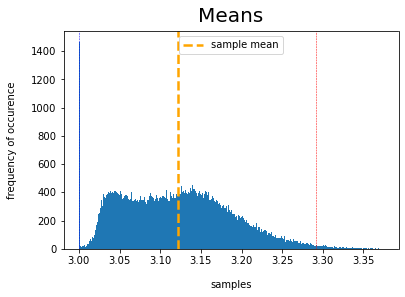

In [5]:
plt.hist(result_list,bins=500)

plt.title("Means", y=1.015, fontsize=20)
plt.axvline(x=sum(result_list)/len(result_list), linestyle='--', linewidth=2.5, label="sample mean", c='orange')
plt.xlabel("samples", labelpad=14)
plt.ylabel("frequency of occurence", labelpad=14)
plt.legend();

result_list.sort()

plt.axvline(x=result_list[int(len(result_list)*0.01)], linestyle='--', linewidth=0.5, label="1%", c='b')
plt.axvline(x=result_list[int(len(result_list)*0.99)], linestyle='--', linewidth=0.5, label="99%", c='r')


plt.show()

In [6]:
training_supervised_label=np.array(training_supervised_label)
print(training_supervised_label)

[[1.3717089  1.51900977 0.93691971 1.99192572]
 [2.03438148 2.3544678  1.99021017 2.41350184]
 [1.77541114 1.94036937 1.4438688  2.17010622]
 ...
 [1.90713332 1.89199411 1.85489047 1.79108111]
 [2.41303777 2.70115414 2.64758957 2.39376076]
 [1.77864597 1.46760094 1.9012413  1.60069221]]


In [7]:
def weight_init(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight, gain=nn.init.calculate_gain('relu'))
        torch.nn.init.zeros_(m.bias)
    elif isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=1.0)
        torch.nn.init.uniform_(m.bias, a=-1.0, b=1.0)
        

class Net(torch.nn.Module):
    def __init__(self):

        super(Net, self).__init__()

        num_input = Agent_number_n-1
        num_hidden = 100
        num_output = 1

        self.hidden_0 = torch.nn.Linear(num_input, num_hidden)
        self.hidden_1 = torch.nn.Linear(num_hidden, num_hidden)
        self.hidden_2 = torch.nn.Linear(num_hidden, num_hidden)
        self.hidden_3 = torch.nn.Linear(num_hidden, num_hidden)
        self.output_allocation = torch.nn.Linear(num_hidden, num_output)

    def calculate(self, value_list):
        h1 = torch.nn.functional.leaky_relu(self.hidden_0(value_list))
        h2 = torch.nn.functional.leaky_relu(self.hidden_1(h1))
        h3 = torch.nn.functional.leaky_relu(self.hidden_2(h2))
        h4 = torch.nn.functional.leaky_relu(self.hidden_3(h3))
        h = torch.relu(self.output_allocation(h4))

        return h

    def forward(self, input_list,input_label,label):
        global iteration,echo,target_order
        loss1 = 0
        loss2 = 0
        h_list = []

        if (target_order == "supervised"):
            loss = 0 
            for i in range(Agent_number_n):
                h = self.calculate(input_list[i])
                loss += torch.square(h - label[i])
                h_list.append(h)
            return loss
        else:
            for i in range(Agent_number_n):
                h = self.calculate(input_list[i])
                h_list.append(h)
                
            sum_h = torch.sum(torch.cat(h_list)).cuda()


            loss1 = torch.where((Agent_number_n-1)*input_label>sum_h,
                            torch.relu((Agent_number_n-1)*input_label-sum_h),
                            torch.zeros(1).cuda()
                          )

            loss2 = torch.where((Agent_number_n-Alpha)*input_label<sum_h,
                            torch.relu(sum_h-(Agent_number_n-Alpha)*input_label),
                            torch.zeros(1).cuda()
                          )

            return loss1,loss2,h_list

In [8]:
def redistribution_value_function(input_tensor):
    S = torch.max(torch.sum(input_tensor), torch.ones(1))
    temp_list = []


    for i in range(Agent_number_n):
        temp = []
        
        for j in range(Agent_number_n):
            if(i != j):
                temp .append(input_tensor[j])
                
        temp = torch.stack(temp)
        temp_list.append(temp)
    return torch.stack(temp_list), S

def Generator(GeneratorNet,DiscriminatorNet):

    opt_D = torch.optim.Adam(DiscriminatorNet.parameters(), lr=LR_D)
    opt_G = torch.optim.Adam(GeneratorNet.parameters(), lr=LR_G)


    DiscriminatorNet.requires_grad = False

    show_list = []
    for step in range(101):
        # real painting from artist
        G_ideas = torch.randn(BATCH_SIZE, N_IDEAS,
                              requires_grad=True)  # random ideas\n
        # fake painting from G (random ideas)
        G_values = GeneratorNet(G_ideas)
    #     print(artist_paintings)
    #     print(G_paintings)

        result_list = []
        for index in range(BATCH_SIZE):
            h_list = []
            value_list_tensor, S_tensor = redistribution_value_function(
                G_values[index])
            for i in range(Agent_number_n):
                h = DiscriminatorNet.calculate(
                    value_list_tensor[i].cuda().type(torch.float32))
                h_list.append(h)
            h_list = torch.stack(h_list)
            result_list.append(torch.sum(h_list)/S_tensor.cuda())
            show_list.append(float(torch.sum(h_list)/S_tensor.cuda()))
        result_list = torch.stack(result_list)

        diff_loss = torch.max(result_list)-torch.min(result_list)
        G_loss = torch.max(- diff_loss)

        opt_G.zero_grad()
        G_loss.backward()
        opt_G.step()

        if step % 100 == 0 and step != 0:  # plotting


            print(max(show_list), min(show_list),
                  max(show_list)-min(show_list))

            plt.hist(show_list, bins=500)

            plt.title("Means", y=1.015, fontsize=20)
            plt.axvline(x=sum(show_list)/len(show_list), linestyle='--',
                        linewidth=2.5, label="sample mean", c='orange')
            plt.xlabel("samples", labelpad=14)
            plt.ylabel("frequency of occurence", labelpad=14)
            plt.legend()

            show_list.sort()
            show_list = []
            plt.show()
    torch.save(GeneratorNet , "save/GeneratorNet_4") 
    
    DiscriminatorNet.requires_grad = True
    return GeneratorNet

In [9]:
random.seed(2000)
torch.manual_seed(256)
net  = Net()
net.apply(weight_init)

net = torch.load("save/Deep_learning_4")
net.to(dev)

Net(
  (hidden_0): Linear(in_features=3, out_features=100, bias=True)
  (hidden_1): Linear(in_features=100, out_features=100, bias=True)
  (hidden_2): Linear(in_features=100, out_features=100, bias=True)
  (hidden_3): Linear(in_features=100, out_features=100, bias=True)
  (output_allocation): Linear(in_features=100, out_features=1, bias=True)
)

In [10]:
#optimizer = opt.RMSprop(net.parameters(), lr=0.00001)
#optimizer = opt.SGD(net.parameters(), lr=0.00001)
optimizer = opt.Adam(net.parameters(), lr=0.00005)

batch_size = 64
echo = 1

In [11]:
target_order = "supervised"
for iteration in range(int(echo)):
    # offender_types = []
    # defender_types = []
    
    
    X_train_list = []
    temp_number = 0
    total_batch_loss = 0 
    while(temp_number<len(training_data)-1):
        loss_sum = 0
        denominator = 0
        for index in range(temp_number, min(batch_size+temp_number,len(training_data))):
            h_loss = net(torch.from_numpy(
            np.array(training_data[index])).cuda().type(torch.float32),training_label[index],training_supervised_label[index])
            denominator += 1
            loss_sum += h_loss
            
        loss = (loss_sum) / denominator 
        total_batch_loss +=float(loss_sum)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        temp_number = index
        
        if(random.random()<=0.01):
            print(temp_number,loss,float(loss_sum))


    print("batch iteration", iteration)
    print("batch_loss: %.2f " % (total_batch_loss/len(training_data)))
    
    print()
    print()

3024 tensor([1.4538], device='cuda:0', grad_fn=<DivBackward0>) 93.04468536376953
4347 tensor([1.0484], device='cuda:0', grad_fn=<DivBackward0>) 67.09664916992188
8883 tensor([0.8844], device='cuda:0', grad_fn=<DivBackward0>) 56.604469299316406
13104 tensor([0.9543], device='cuda:0', grad_fn=<DivBackward0>) 61.07455825805664
16128 tensor([0.7842], device='cuda:0', grad_fn=<DivBackward0>) 50.191219329833984
25011 tensor([0.6485], device='cuda:0', grad_fn=<DivBackward0>) 41.50495529174805
35091 tensor([0.2685], device='cuda:0', grad_fn=<DivBackward0>) 17.185041427612305
36351 tensor([0.2036], device='cuda:0', grad_fn=<DivBackward0>) 13.03161907196045
36666 tensor([0.1898], device='cuda:0', grad_fn=<DivBackward0>) 12.149834632873535
56007 tensor([0.0107], device='cuda:0', grad_fn=<DivBackward0>) 0.6873477101325989
68103 tensor([0.0115], device='cuda:0', grad_fn=<DivBackward0>) 0.7351847290992737
68166 tensor([0.0091], device='cuda:0', grad_fn=<DivBackward0>) 0.5799170732498169
80010 tensor

In [12]:
denominator = 0
result_list = []
for index in range(len(testing_data)):
    h_list = []
    for i in range(Agent_number_n):
        h = net.calculate(torch.tensor(testing_data[index][i]).cuda().type(torch.float32))
        h_list.append(float(h))
    
    #print(sum(h_list),h_list,sum(h_list)/testing_label[index])
    result_list.append(sum(h_list)/testing_label[index])
    

print(max(result_list),min(result_list),max(result_list)-min(result_list))

3.4134374437937627 1.7764075994491577 1.637029844344605


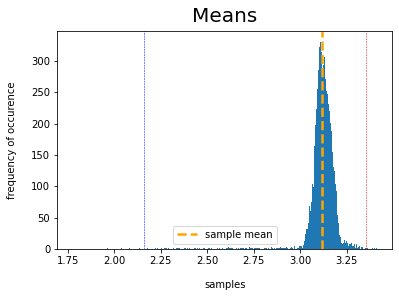

In [13]:
plt.hist(result_list,bins=500)

plt.title("Means", y=1.015, fontsize=20)
plt.axvline(x=sum(result_list)/len(result_list), linestyle='--', linewidth=2.5, label="sample mean", c='orange')
plt.xlabel("samples", labelpad=14)
plt.ylabel("frequency of occurence", labelpad=14)
plt.legend();

result_list.sort()

plt.axvline(x=result_list[int(len(result_list)*0.001)], linestyle='--', linewidth=0.5, label="0.1%", c='b')
plt.axvline(x=result_list[int(len(result_list)*0.999)], linestyle='--', linewidth=0.5, label="99%", c='r')


plt.show()

In [14]:
torch.save(net, "save/Deep_learning_4")

In [15]:
#optimizer = opt.RMSprop(net.parameters(), lr=0.00001)
#optimizer = opt.SGD(net.parameters(), lr=0.00005)
optimizer = opt.Adam(net.parameters(), lr=0.000001)

batch_size = 64
echo = 0



In [16]:
target_order = "unsupervised"
for iteration in range(int(echo)):
    # offender_types = []
    # defender_types = []
    
    GeneratorNet = Generator(GeneratorNet,net)
    
    
    X_train_list = []
    total_batch_loss = 0 
    for i in range(1001):
        
        G_ideas = torch.randn(BATCH_SIZE, N_IDEAS,
                                  requires_grad=True)  
        G_values = GeneratorNet(G_ideas)
         
        loss1_sum = 0
        loss2_sum = 0
        
        for index in range(BATCH_SIZE):
            h_list = []
            value_list_tensor, S_tensor = redistribution_value_function(
                G_values[index])
            

            h_loss1,h_loss2,h_list = net(value_list_tensor.cuda().type(torch.float32), S_tensor.cuda(),0)
            loss1_sum += h_loss1
            loss2_sum += h_loss2
        
        loss_sum = loss1_sum + loss2_sum
        loss = (loss_sum) / BATCH_SIZE
        total_batch_loss +=float(loss_sum)
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
        
        if(random.random()<=0.01):
            print(i,loss,float(loss1_sum),float(loss2_sum))


    print( iteration,"batch iteration", iteration)
    print("batch_loss: %.2f " % (total_batch_loss/len(training_data)))
    
    print()
    print()

In [17]:
torch.save(net, "save/Deep_learning_4")

In [18]:
denominator = 0
result_list = []
for index in range(len(testing_data)):
    h_list = []
    for i in range(Agent_number_n):
        h = net.calculate(torch.tensor(testing_data[index][i]).cuda().type(torch.float32))
        h_list.append(float(h))
    
    #print(sum(h_list),h_list,sum(h_list)/testing_label[index])
    result_list.append(sum(h_list)/testing_label[index])
    

print(max(result_list),min(result_list),max(result_list)-min(result_list))

3.4134374437937627 1.7764075994491577 1.637029844344605


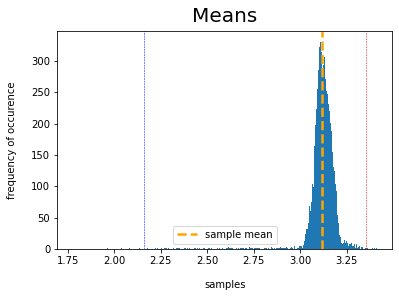

In [19]:
plt.hist(result_list,bins=500)

plt.title("Means", y=1.015, fontsize=20)
plt.axvline(x=sum(result_list)/len(result_list), linestyle='--', linewidth=2.5, label="sample mean", c='orange')
plt.xlabel("samples", labelpad=14)
plt.ylabel("frequency of occurence", labelpad=14)
plt.legend();

result_list.sort()

plt.axvline(x=result_list[int(len(result_list)*0.001)], linestyle='--', linewidth=0.5, label="0.1%", c='b')
plt.axvline(x=result_list[int(len(result_list)*0.999)], linestyle='--', linewidth=0.5, label="99%", c='r')


plt.show()